In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import numpy as np


2024-06-07 10:53:50.053774: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 10:53:50.861924: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


ModuleNotFoundError: No module named 'sklearn'

In [123]:
# execs 'head' and 'mv' appear with somewhat equal frequency and avg/median length
# try to train a binary classifier to distinguish between them

In [3]:
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import os

In [125]:
# setup connection
conn = psycopg2.connect(
    host='localhost',
    database='cadets_e3',
    user='rosendahl',
)
conn.set_session(readonly=True)
# get cursor
cur = conn.cursor()

In [4]:
# debug
os.system("hostnamectl hostname")
print(f'current working directory: {os.getcwd()}')

absolute-unit
current working directory: /home/jrosendahl/sync/models


In [127]:
classes = ['bash', 'sleep', 'vmstat', 'sh', 'imapd', 'top', 'date', 'lsof', 'head', 'mv']

In [128]:
# alternative selection of classes
num_classes = 135

query = '''
select exec, count(*) as count
from sequence
group by exec
order by count desc
limit %s;
'''

cur.execute(query, (num_classes,))

classes_result = cur.fetchall()
classes = [x[0] for x in classes_result if x[1] >= 10]
class_weights = {}
for i in range(len(classes)):
    class_weights[i] = classes_result[i][1]

print(f'number of classes: {len(classes)}')
print(f'bottom classes has occurrences: {classes_result[-1][1]}')
classes

number of classes: 77
bottom classes has occurrences: 1


['bash',
 'sleep',
 'vmstat',
 'sh',
 'imapd',
 'top',
 'date',
 'lsof',
 'head',
 'mv',
 'cron',
 'master',
 'mlock',
 'sshd',
 'inetd',
 'atrun',
 'local',
 'smtpd',
 'sysctl',
 'dd',
 'unlink',
 'proxymap',
 'resizewin',
 'fortune',
 'cleanup',
 'trivial-rewrite',
 'alpine',
 'anvil',
 'python2.7',
 'rm',
 'netstat',
 'cat',
 'sendmail',
 'newsyslog',
 'find',
 'mkdir',
 'wget',
 'dmesg',
 'uptime',
 'pkg',
 'pickup',
 'hostname',
 'adjkerntz',
 'dhclient',
 'wc',
 'route',
 'mktemp',
 'sudo',
 'ls',
 'grep',
 'ps',
 'awk',
 'cmp',
 'lockf',
 'mailwrapper',
 'egrep',
 'mail',
 'sort',
 'sed',
 'mount',
 'expr',
 'tty',
 'links',
 'kenv',
 'nginx',
 'less',
 'bzcat',
 'cp',
 'bzip2',
 'df',
 'kill',
 'chkgrp',
 'xz',
 'basename',
 'msgs',
 'screen',
 'tr']

In [129]:
# get all possible event types
query = '''
select distinct type
from event e
where e.properties_map_exec in %s
'''

cur.execute(query, (tuple(classes),))

event_types = cur.fetchall()
event_types = [x[0] for x in event_types]
event_types

['EVENT_ACCEPT',
 'EVENT_BIND',
 'EVENT_CHANGE_PRINCIPAL',
 'EVENT_CLOSE',
 'EVENT_CONNECT',
 'EVENT_CREATE_OBJECT',
 'EVENT_EXECUTE',
 'EVENT_EXIT',
 'EVENT_FCNTL',
 'EVENT_FORK',
 'EVENT_LINK',
 'EVENT_LOGIN',
 'EVENT_LSEEK',
 'EVENT_MMAP',
 'EVENT_MODIFY_FILE_ATTRIBUTES',
 'EVENT_MODIFY_PROCESS',
 'EVENT_MPROTECT',
 'EVENT_OPEN',
 'EVENT_OTHER',
 'EVENT_READ',
 'EVENT_RECVFROM',
 'EVENT_RECVMSG',
 'EVENT_RENAME',
 'EVENT_SENDMSG',
 'EVENT_SENDTO',
 'EVENT_SIGNAL',
 'EVENT_TRUNCATE',
 'EVENT_UNLINK',
 'EVENT_WRITE']

In [130]:
query = f'''
select e.subject_uuid, e.properties_map_exec, e.type, count(*) as count
from event e
where e.properties_map_exec in %s
group by subject_uuid, properties_map_exec, type
order by subject_uuid, properties_map_exec, type
'''

# write to csv

event_type_to_index = {event_types[i]: i for i in range(len(event_types))}
csv_header = 'subject_uuid,properties_map_exec,' + ','.join(event_types)

with open('data.csv', 'w') as f:
    f.write(csv_header + '\n')
    cur.execute(query, (tuple(classes),))

    current_subject_uuid = None
    current_exec = None
    current_counts = [0 for _ in range(len(event_types))]

    lines_written = 0
    for row in cur:
        subject_uuid = row[0]
        exec_type = row[1]
        event_type = row[2]
        count = row[3]
        
        if subject_uuid != current_subject_uuid or exec_type != current_exec:
            # next sequence, write prev sequence to csv
            if current_subject_uuid is not None:
                f.write(current_subject_uuid + ',' + current_exec + ',' + ','.join(map(str, current_counts)) + '\n')
                lines_written += 1
            # reset current sequence
            current_counts = [0 for _ in range(len(event_types))]
            # update current sequence identifiers
            current_subject_uuid = subject_uuid
            current_exec = exec_type
            current_counts[event_type_to_index[event_type]] = count
        
        else:
            # still in sequence
            current_counts[event_type_to_index[event_type]] = count
    print(f'number of sequences written to file: {lines_written}')

number of sequences written to file: 431571


In [5]:
import pandas as pd

df = pd.read_csv('~/datasets/data.csv')
df.head()


,subject_uuid,properties_map_exec,EVENT_ACCEPT,EVENT_BIND,EVENT_CHANGE_PRINCIPAL,EVENT_CLOSE,EVENT_CONNECT,EVENT_CREATE_OBJECT,EVENT_EXECUTE,EVENT_EXIT,...,EVENT_READ,EVENT_RECVFROM,EVENT_RECVMSG,EVENT_RENAME,EVENT_SENDMSG,EVENT_SENDTO,EVENT_SIGNAL,EVENT_TRUNCATE,EVENT_UNLINK,EVENT_WRITE
0,00002710-3DF2-11E8-A5CB-3FA3753A265A,bash,0,0,0,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,00002710-3DF2-11E8-A5CB-3FA3753A265A,vmstat,0,0,0,10,0,0,0,1,...,3,0,0,0,0,0,0,0,0,3
2,0000418D-3893-11E8-BF66-D9AA8AFF4A69,bash,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0000418D-3893-11E8-BF66-D9AA8AFF4A69,sleep,0,0,0,4,0,0,0,1,...,3,0,0,0,0,0,0,0,0,0
4,0000464B-38D0-11E8-BF66-D9AA8AFF4A69,bash,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
print(f'number of rows: {len(df)}')
print(f'number of columns: {len(df.columns)}')
print(f'number of duplicates: {df.duplicated().sum()}')

number of rows: 431571
number of columns: 31
number of duplicates: 0


In [7]:
# drop subject_uuid column
df = df.drop(columns=['subject_uuid'])

df.head()

,properties_map_exec,EVENT_ACCEPT,EVENT_BIND,EVENT_CHANGE_PRINCIPAL,EVENT_CLOSE,EVENT_CONNECT,EVENT_CREATE_OBJECT,EVENT_EXECUTE,EVENT_EXIT,EVENT_FCNTL,...,EVENT_READ,EVENT_RECVFROM,EVENT_RECVMSG,EVENT_RENAME,EVENT_SENDMSG,EVENT_SENDTO,EVENT_SIGNAL,EVENT_TRUNCATE,EVENT_UNLINK,EVENT_WRITE
0,bash,0,0,0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,vmstat,0,0,0,10,0,0,0,1,0,...,3,0,0,0,0,0,0,0,0,3
2,bash,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,sleep,0,0,0,4,0,0,0,1,0,...,3,0,0,0,0,0,0,0,0,0
4,bash,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# split data into train and test
from sklearn.model_selection import train_test_split

X = df.drop(columns=['properties_map_exec'])
y = df['properties_map_exec']

# convert 'head' to 0 and 'mv' to 1
# y = y.apply(lambda x: 0 if x == 'head' else 1)
# convert y to one-hot encoding
y = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

# print first 5 rows of X_train
#X_train.head()

# print first 5 rows of y_train
y_train.head()



X_train shape: (345256, 29)
X_test shape: (86315, 29)
y_train shape: (345256, 77)
y_test shape: (86315, 77)


,adjkerntz,alpine,anvil,atrun,awk,basename,bash,bzcat,bzip2,cat,...,top,tr,trivial-rewrite,tty,unlink,uptime,vmstat,wc,wget,xz
254096,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99807,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
236226,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
191194,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
117592,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
# train a classifier

#num_classes = len(classes)
num_classes = len(y_train.columns)
num_features = len(X.columns)
# the input shape is a vector of length num_features
input_shape = (num_features,)

print(f'num_classes: {num_classes}')
print(f'num_features: {num_features}')

num_classes: 77
num_features: 29


In [11]:
model = keras.Sequential([
    keras.layers.Input(input_shape),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 77)             │         5,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,245 (59.55 KB)

 Trainable params: 15,245 (59.55 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#history = model.fit(X_train, y_train, epochs=200, validation_split=.2, class_weight=class_weights)
history = model.fit(X_train, y_train, epochs=200, validation_split=.2, callbacks=[callback])


Epoch 1/200
8632/8632 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - categorical_accuracy: 0.9351 - loss: 0.6926 - val_categorical_accuracy: 0.9429 - val_loss: 0.2054
Epoch 2/200
8632/8632 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - categorical_accuracy: 0.9376 - loss: 0.3855 - val_categorical_accuracy: 0.9416 - val_loss: 0.2209
Epoch 3/200
8632/8632 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - categorical_accuracy: 0.9387 - loss: 0.4557 - val_categorical_accuracy: 0.9443 - val_loss: 0.2894
Epoch 4/200
8632/8632 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - categorical_accuracy: 0.9387 - loss: 0.4379 - val_categorical_accuracy: 0.9438 - val_loss: 0.4020
Epoch 5/200
8632/8632 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - categorical_accuracy: 0.9390 - loss: 0.4673 - val_categorical_accuracy: 0.9445 - val_loss: 0.1915
Epoch 6/200
8632/8632 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - categorical_accuracy: 0.9396 - loss: 0.8807 - val_categorical_accuracy: 0.9443 - val_loss: 0.4085
Epoch 7/200
8632/8632 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - catego

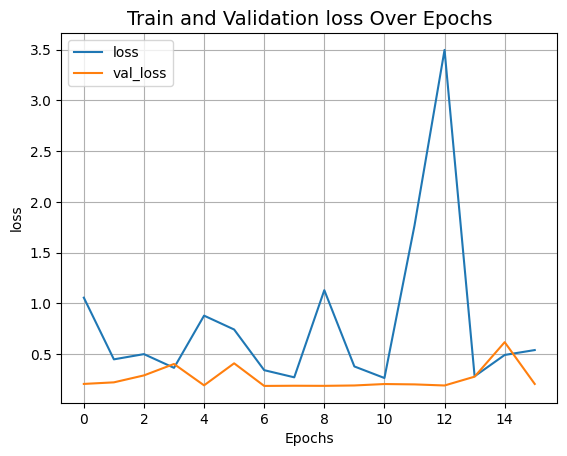

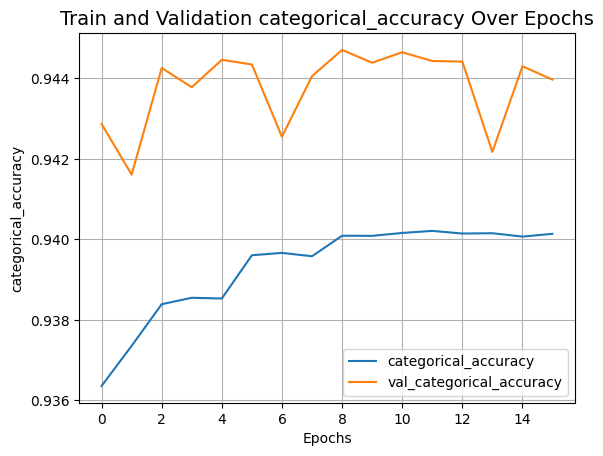

In [14]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")


In [15]:
# predict on test data and evaluate
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(np.array(y_test), axis=1)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

2698/2698 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       1.00      0.46      0.63       213
           2       1.00      0.92      0.96       171
           3       1.00      1.00      1.00       623
           4       1.00      1.00      1.00         8
           5       0.00      0.00      0.00         2
           6       0.95      0.97      0.96     32085
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         1
           9       0.93      0.93      0.93        71
          10       0.00      0.00      0.00         3
          11       1.00      1.00      1.00       213
          12       0.90      0.82      0.86        11
          13       1.00      1.00      1.00        72
          14       1.00      1.00      1.00      2018
          15       1.00      1.00      1.00      3059
          16       1.00      1.00     

/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [17]:
# save model
model.save('model_saves/ff_event_type_counts.keras')

In [140]:
# destroy cursor and connection
cur.close()
conn.close()